In [9]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from matplotlib.image import imread
from PIL import Image, ImageOps

## Read in styles.csv
Includes picture Ids and category info

In [10]:
category_info = pd.read_csv('styles.csv', usecols = (0,1,2,3,4,5,6,7,8,9))

print("Original shape: {}".format(category_info.shape))
print(category_info.head)

Original shape: (44446, 10)
<bound method NDFrame.head of           id gender masterCategory subCategory            articleType  \
0      15970    Men        Apparel     Topwear                 Shirts   
1      39386    Men        Apparel  Bottomwear                  Jeans   
2      59263  Women    Accessories     Watches                Watches   
3      21379    Men        Apparel  Bottomwear            Track Pants   
4      53759    Men        Apparel     Topwear                Tshirts   
...      ...    ...            ...         ...                    ...   
44441  17036    Men       Footwear       Shoes           Casual Shoes   
44442   6461    Men       Footwear  Flip Flops             Flip Flops   
44443  18842    Men        Apparel     Topwear                Tshirts   
44444  46694  Women  Personal Care   Fragrance  Perfume and Body Mist   
44445  51623  Women    Accessories     Watches                Watches   

      baseColour  season    year   usage  \
0      Navy Blue    F

## Filter out irrelevant categories 

In [11]:
#Filter out certain master categories
category_info = category_info[category_info['masterCategory'].isin(['Apparel','Accessories','Footwear'])]
#Filter out certain sub-categories
category_info = category_info[category_info['subCategory'].isin(['Topwear', 'Bottomwear',  'Shoes' , 'Flip Flops',
 'Bags',  'Sandal' , 'Dress'])]

id_category = category_info.filter(items = ['id', 'subCategory'])

category_info = category_info[~category_info['articleType'].isin(['Skirts', 
'Shrug', 
'Dupatta', 
'Tracksuits', 
'Swimwear',  
'Jumpsuit', 
'Suspenders',
'Salwar and Dupatta', 
'Patiala', 
'Stockings',
'Tights', 
'Churidar',
 'Tablet Sleeve', 
 'Wallets', 
'Rompers',
 'Waist Pouch',
'Belts',
 'Suits',
 'Travel Accessory'])]
print("Filtered shape: {}".format(category_info.shape))

#get only id, subCategory and article type columns
id_category = category_info.filter(items = ['id', 'subCategory', 'articleType'])
print("Article type column values: ")
print(id_category['articleType'].unique())

Filtered shape: (30351, 10)
Article type column values: 
['Shirts' 'Jeans' 'Track Pants' 'Tshirts' 'Casual Shoes' 'Flip Flops'
 'Handbags' 'Tops' 'Sandals' 'Sweatshirts' 'Formal Shoes' 'Flats' 'Kurtas'
 'Waistcoat' 'Sports Shoes' 'Shorts' 'Heels' 'Laptop Bag' 'Rain Jacket'
 'Dresses' 'Blazers' 'Clutches' 'Backpacks' 'Trousers' 'Capris' 'Tunics'
 'Jackets' 'Duffel Bag' 'Sports Sandals' 'Sweaters' 'Trolley Bag'
 'Leggings' 'Kurtis' 'Mobile Pouch' 'Messenger Bag' 'Nehru Jackets'
 'Salwar' 'Jeggings' 'Rucksacks' 'Lehenga Choli' 'Rain Trousers']


## Read in image data and invert

In [12]:
#Create list of image ids for the dataset
    #Note: not all ids are present in the image folder
valid_ids = id_category['id'].tolist()

#create numpy array with images
to_numpy = []
valid_ids2 = []


for id in valid_ids:
    try:
        #wrap in ImageOps invert to invert colors
        a = np.array(ImageOps.invert(Image.open('images/'+ str(id) + '.jpg' )))
        if a.shape == (80,60,3):
            to_numpy.append(a)
            valid_ids2.append(id)
    except FileNotFoundError:
        continue
im_array = np.array(to_numpy)
print(im_array.shape)

#update id information based on the images that were actually there
id_category = id_category[id_category['id'].isin(valid_ids2)]

(30175, 80, 60, 3)


## Recode Labels to fit MNIST

In [13]:
#create dictionary with id and new label based on fashion MNIST
label_arr = np.zeros(shape=(len(valid_ids2),1))
count = 0

for i in range(44444):
    try:
        if id_category['articleType'][i] in ['Tshirts', 'Tops']:
            label_arr[count]= 0
        elif id_category['articleType'][i] in ['Jeans', 'Track Pants', 'Trousers', 'Rain Trousers', 'Leggings', 'Jeggings', 'Shorts', 'Capris']:
            label_arr[count]= 1
        elif id_category['articleType'][i] in ['Sweatshirts','Sweaters']:
            label_arr[count]= 2
        elif id_category['articleType'][i] in ['Dresses', 'Tunics', 'Kurtas', 'Kurtis', 'Churidar', 'Salwar', 'Lehenga Choli']:
            label_arr[count]= 3
        elif id_category['articleType'][i] in ['Rain Jacket', 'Waistcoat', 'Blazers', 'Jackets', 'Nehru Jackets']:
            label_arr[count]= 4
        elif id_category['articleType'][i] in ['Flip Flops', 'Sandals', 'Sports Sandals']:
            label_arr[count]= 5
        elif id_category['articleType'][i] in ['Shirts']:
            label_arr[count]= 6
        elif id_category['articleType'][i] in ['Casual Shoes', 'Sports Shoes', 'Flats']:
            label_arr[count]= 7
        elif id_category['articleType'][i] in ['Handbags', 'Laptop Bag', 'Backpacks', 'Clutches', 'Duffel Bag', 'Trolley Bag', 'Mobile Pouch', 'Messenger Bag','Rucksacks']:
            label_arr[count]= 8
        elif id_category['articleType'][i] in ['Formal Shoes','Heels']:
            label_arr[count]= 9
        count = count + 1
    except KeyError:
        continue

print(label_arr.shape)

(30175, 1)


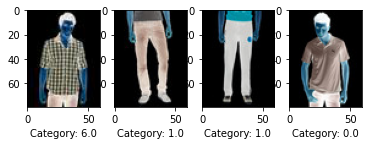

In [14]:
#test if it worked
for i in range(4):
    plt.subplot(1, 4 ,i+1)
    plt.imshow(im_array[i])
    label = 'Category: ' + str(label_arr[i,0])
    plt.xlabel(label)
plt.show()


## Write out data

In [15]:
#write out arrays
np.save('labelsFashionImages', label_arr)
np.save('imagesFashionImages', im_array)


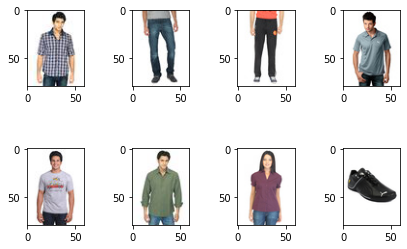

In [55]:
#for slideshow: display images that are normal color:
to_numpy2 = []
for id in valid_ids2:
    try:
        a = np.array(Image.open('images/'+ str(id) + '.jpg' ))
        if a.shape == (80,60,3):
            to_numpy2.append(a)
    except FileNotFoundError:
        continue
norm_color = np.array(to_numpy2)

fig, axs = plt.subplots(2, 4)
fig.tight_layout()
for i, ax in enumerate(axs.flat):
    ax.imshow(norm_color[i])
plt.savefig('first_8_normal.png')    
plt.show()